<div align="center"><h3>HW1</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

# Loading Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np
import tensorflow as tf

# Initializing

Reading the dataset

In [3]:
with open('data/train.txt') as f:
    train = f.read().split('\n')
with open('data/validation.txt') as f:
    val = f.read().split('\n')
with open('data/test.txt') as f:
    test = f.read().split('\n')
with open('data/test_incomplete.txt') as f:
    test_inc = f.read().split('\n')
with open('data/test_incomplete_gold.txt') as f:
    test_gld = f.read().split('\n')

# Statistical Langauge Models

## Unigram

In [20]:
class Unigram:
    def __init__(self):
        self.uni_delta = 0
        self.vocab = set()
        self.vocab_size = 0
        self.word_count = 0
        self.unigram = dict()

    def _create_model(self, train):
        for verse in train:
            verse_ = list(filter(lambda str_: str_, verse.split(' ')))
            for w in verse_:
                self._update_zerogram(w)
                self._update_unigram(w)

    def _calculate_probablity(self, w, uni_delta):
        a1 = (uni_delta / self.word_count) * self.vocab_size
        return max(self.unigram.get(w, 0) - uni_delta, 0) / self.word_count +  \
                    a1 * 1 / self.vocab_size

    def _calculate_perplexity(self, val, uni_delta):
        N = 0
        total_prob = 1
        for verse in val:
            verse_ = list(filter(lambda str_: str_, verse.split(' ')))
            for w in verse_:
                total_prob -= np.log(self._calculate_probablity(w, uni_delta))
                N += 1
        return (1/N) * total_prob

    def _tune_parameter(self, val):
        best_pp = float('inf')
        for uni_delta in np.arange(0.02, 0.98, 0.02):
            pp = self._calculate_perplexity(val, uni_delta)
            if pp < best_pp:
                best_pp = pp
                self.uni_delta = uni_delta

    def fit(self, train, val):
        self._create_model(train)
        self._tune_parameter(val)

    def _update_zerogram(self, w):
        self.vocab.add(w)
        self.vocab_size = len(self.vocab)
        self.word_count += 1

    def _update_unigram(self, w):
        if w not in self.unigram:
            self.unigram[w] = 0
        self.unigram[w] += 1

    def predict(self, missing_words):
        predicted_words = []
        for _ in range(missing_words):
            best_prob, selected_w = 0, ''
            for w in self.unigram:
                p = self._calculate_probablity(w, self.uni_delta)
                if best_prob < p:
                    best_prob = p
                    selected_w = w
            predicted_words.append(selected_w)
        return predicted_words

Training unigram model

In [21]:
unigram = Unigram()
unigram.fit(train, val)

Best value for delta parameter

In [22]:
print('delta=', unigram.uni_delta)

delta= 0.9600000000000001


Reporting perplexity on validation set:

In [23]:
logppl = unigram._calculate_perplexity(val, unigram.uni_delta)
print('Perplexity on Validation Data', np.exp(logppl))

Perplexity on Validation Data 1828.5071918543797


Reporting perplexity on test set:

In [24]:
logppl = unigram._calculate_perplexity(test, unigram.uni_delta)
print('Perplexity on Test Data', np.exp(logppl))

Perplexity on Test Data 1810.0729902351718


Predicting tokens on `test_incomplete.txt` verses.

In [25]:
for ins in test_inc:
    missing_words, verse = ins.split('###')
    predicted_words = unigram.predict(int(missing_words))
    print(verse, predicted_words)

این سخن حقست اگر نزد سخن گستر ['و']
آنکه با یوسف صدیق چنین خواهد ['و']
هیچ دانی چکند صحبت او با ['و']
سرمه دهی بصر بری سخت خوش است ['و']
آتش ابراهیم را ['و', 'و']
من که اندر سر ['و', 'و']
هر شیر شرزه را که به نیش ['و', 'و']
هرکه از حق به ['و', 'و', 'و']
گفت این از ['و', 'و', 'و']
کلاه لاله که لعل است ['و', 'و', 'و']


## Bigram

### Implementation

In [27]:
class Bigram:
    def __init__(self):
        self.bi_delta = 0
        self.uni_delta = 0
        self.vocab = set()
        self.vocab_size = 0
        self.word_count = 0
        self.unigram = dict()
        self.bigram = dict()
        self.w_max = 0

    def bi_B(self, w_prev):
        return len(self.bigram[w_prev].keys())

    def uni_B(self):
        return self.vocab_size

    def _create_model(self, train):
        for verse in train:
            verse_ = list(filter(lambda str_: str_, verse.split(' ')))
            for i, w in enumerate(verse_):
                self._update_zerogram(w)
                self._update_unigram(w)
                self._update_bigram(w, verse_[i-1])

    def _calculate_probablity(self, w, w_prev, bi_delta, uni_delta):
        if w_prev in self.bigram:
            a1 = (bi_delta / self.unigram[w_prev]) * self.bi_B(w_prev)
            a2 = (uni_delta / self.word_count) * self.uni_B()
            return max(self.bigram[w_prev].get(w, 0) - bi_delta, 0) / self.unigram[w_prev] + \
                    a1 * (max(self.unigram.get(w, 0) - uni_delta, 0) / self.word_count +  \
                        a2 * 1 / self.vocab_size)
        else:
            a2 = (uni_delta / self.word_count) * self.uni_B()
            return max(self.unigram.get(w, 0) - uni_delta, 0) / self.word_count +  \
                        a2 * 1 / self.vocab_size

    def _calculate_perplexity(self, val, bi_delta, uni_delta):
        N = 0
        total_prob = 1
        for verse in val:
            verse_ = list(filter(lambda str_: str_, verse.split(' ')))
            for i, w in enumerate(verse_):
                total_prob -= np.log(self._calculate_probablity(w, verse_[i-1], bi_delta, uni_delta))
                N += 1
        return (1/N) * total_prob

    def _tune_parameter(self, val):
        best_pp = float('inf')
        for bi_delta in np.arange(0.05, 0.95, 0.05):
            for uni_delta in np.arange(0.05, 0.95, 0.05):
                pp = self._calculate_perplexity(val, bi_delta, uni_delta)
                if pp < best_pp:
                    best_pp = pp
                    self.bi_delta = bi_delta
                    self.uni_delta = uni_delta

    def fit(self, train, val):
        self._create_model(train)
        self._tune_parameter(val)

    def _update_zerogram(self, w):
        self.vocab.add(w)
        self.vocab_size = len(self.vocab)
        self.word_count += 1

    def _update_unigram(self, w):
        if w not in self.unigram:
            self.unigram[w] = 0
        self.unigram[w] += 1

    def _update_bigram(self, w, w_prev):
        if w_prev not in self.bigram:
            self.bigram[w_prev] = dict()
        if w not in self.bigram[w_prev]:
            self.bigram[w_prev][w] = 0
        self.bigram[w_prev][w] += 1

    def predict(self, verse, missing_words):
        predicted_words = []
        last_word = verse[-1]
        for _ in range(missing_words):
            best_prob, selected_w = 0, ''
            for w in self.unigram:
                p = self._calculate_probablity(w, last_word, self.bi_delta, self.uni_delta)
                if best_prob < p:
                    best_prob = p
                    selected_w = w
            last_word = selected_w
            predicted_words.append(selected_w)
        return predicted_words

Training bigram model

In [28]:
bigram = Bigram()
bigram.fit(train, val)

Best Parameter for delta1 and delta2

In [32]:
print('delta1=', bigram.uni_delta, 'delta2=', bigram.bi_delta)

delta1= 0.9000000000000001 delta2= 0.9000000000000001


Perplexity on validation dataset:

In [34]:
logppl = bigram._calculate_perplexity(val, bigram.bi_delta, bigram.uni_delta)
print('Perplexity on Validation data:', np.exp(logppl))

Perplexity on Validation data: 1223.1599054790358


Perplexity on test dataset:

In [35]:
logppl = bigram._calculate_perplexity(test, bigram.bi_delta, bigram.uni_delta)
print('Perplexity on Test data:', np.exp(logppl))

Perplexity on Test data: 1217.7156570556717


Predicting tokens on `test_incomplete.txt` verses.

In [36]:
for ins in test_inc:
    missing_words, verse = ins.split('###')
    predicted_words = bigram.predict(verse, int(missing_words))
    print(verse, predicted_words)

این سخن حقست اگر نزد سخن گستر ['و']
آنکه با یوسف صدیق چنین خواهد ['ر']
هیچ دانی چکند صحبت او با ['و']
سرمه دهی بصر بری سخت خوش است ['را']
آتش ابراهیم را ['و', 'از']
من که اندر سر ['و', 'از']
هر شیر شرزه را که به نیش ['در', 'آن']
هرکه از حق به ['ر', 'و', 'از']
گفت این از ['تو', 'در', 'آن']
کلاه لاله که لعل است ['را', 'به', 'دست']


## Neural Language Model

Determining train, validation and test dataset.

In [4]:
NGRAMS = 4
train_30_000 = train[:30_000]

Constructing Dictionary

In [5]:
def get_vocabluary(dataset):
    vocab = set()
    dataset_len = len(dataset)
    for i in range(dataset_len):
        verse = dataset[i]
        words = verse.split(' ')
        for w in words:
            vocab.add(w)
    vocab.add('<UNK>')
    vocab2id = {t: i for i, t in enumerate(vocab)}
    return vocab2id, vocab

vocab2id, vocab = get_vocabluary(train_30_000)

Encoding inputs as integer encoding & output as one hot encoding.

In [6]:
def dataset_encoder(dataset, n_gram):
    def count_ngram():
        n_gram_cnt = 0
        for verse in dataset:
            words = list(filter(lambda str_: str_, verse.split(' ')))
            grams = [words[i:i+n_gram] for i in range(len(words)-n_gram+1)]
            n_gram_cnt += len(grams)
        return n_gram_cnt

    def integer_encoder(n_gram_cnt):
        arr = np.zeros((n_gram_cnt, n_gram-1), dtype=np.int16)
        gram_id = -1
        for verse in dataset:
            words = list(filter(lambda str_: str_, verse.split(' ')))
            grams = [words[i:i+n_gram] for i in range(len(words)-n_gram+1)]
            for gram in grams:
                gram_id += 1
                for i, w in enumerate(gram[:-1]):
                    arr[gram_id][i] = vocab2id.get(w, vocab2id['<UNK>'])
        return arr

    def one_hot_encoder(n_gram_cnt):
        arr = np.zeros((n_gram_cnt, len(vocab)), dtype=np.int8)
        gram_id = -1
        for verse in dataset:
            words = list(filter(lambda str_: str_, verse.split(' ')))
            grams = [words[i:i+n_gram] for i in range(len(words)-n_gram+1)]
            for gram in grams:
                gram_id += 1
                index = vocab2id.get(gram[-1], vocab2id.get('<UNK>'))
                arr[gram_id][index] = 1
        return arr

    n_gram_cnt = count_ngram()
    X = integer_encoder(n_gram_cnt)
    y = one_hot_encoder(n_gram_cnt)
    return X, y

In [7]:
X_train, y_train = dataset_encoder(train_30_000, NGRAMS)
X_val, y_val = dataset_encoder(val, NGRAMS)
X_test, y_test = dataset_encoder(test, NGRAMS)

Specifying the model

In [8]:
model = tf.keras.Sequential([
	tf.keras.layers.Input((NGRAMS-1,), name="input"),
	tf.keras.layers.Embedding(len(vocab), 128, name="embedding"),
	tf.keras.layers.Flatten(name="Flatten"),
	tf.keras.layers.Dense(256, activation='relu'),
	tf.keras.layers.Dense(len(vocab), activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, batch_size=1024)

Epoch 1/10
119/119 [==============================] - 35s 297ms/step - loss: 8.3645 - accuracy: 0.0446 - val_loss: 7.6852 - val_accuracy: 0.0501
Epoch 2/10
119/119 [==============================] - 35s 292ms/step - loss: 7.4614 - accuracy: 0.0515 - val_loss: 7.6905 - val_accuracy: 0.0501
Epoch 3/10
119/119 [==============================] - 35s 296ms/step - loss: 7.3398 - accuracy: 0.0517 - val_loss: 7.7055 - val_accuracy: 0.0520
Epoch 4/10
119/119 [==============================] - 35s 291ms/step - loss: 7.1984 - accuracy: 0.0553 - val_loss: 7.6866 - val_accuracy: 0.0570
Epoch 5/10
119/119 [==============================] - 34s 286ms/step - loss: 7.0322 - accuracy: 0.0633 - val_loss: 7.6953 - val_accuracy: 0.0633
Epoch 6/10
119/119 [==============================] - 34s 284ms/step - loss: 6.8495 - accuracy: 0.0727 - val_loss: 7.7339 - val_accuracy: 0.0666
Epoch 7/10
119/119 [==============================] - 34s 288ms/step - loss: 6.6490 - accuracy: 0.0837 - val_loss: 7.7990 - val_ac

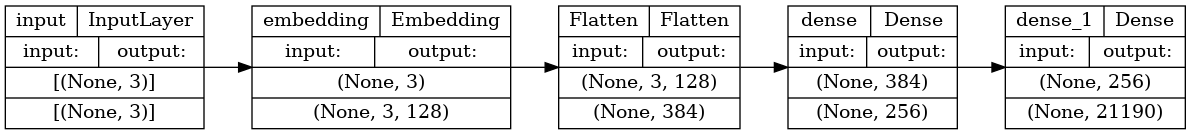

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Perplexity in neural network

In [11]:
N = 0
total_prob = 0
model_output = model.predict(X_test)
for i, y_ in enumerate(y_test):
    idx = np.argmax(y_)
    total_prob -= np.log(model_output[i][idx])
    N += 1
print(f'{NGRAMS} Neural network perplexity: {np.exp((1/N) * total_prob)}')

4 Neural network perplexity: 4129.806574588296


In [12]:
def find_word_by_id(vocab2id, word_id):
    for w in vocab2id:
        if vocab2id[w] == word_id:
            return w

In [13]:
for ins in test_inc:
    missing_words, verse = ins.split('###')
    missing_words = int(missing_words)
    print(verse, end=' ')
    words = verse.split(' ')
    for i in range(missing_words):
        grams = [vocab2id.get(words[-i], vocab2id['<UNK>']) for i in range(1, NGRAMS)]
        predicted_word = find_word_by_id(vocab2id, np.argmax(model.predict([grams])))
        print(predicted_word, end=' ')
        words.append(predicted_word)
    print()

این سخن حقست اگر نزد سخن گستر تو 
آنکه با یوسف صدیق چنین خواهد را 
هیچ دانی چکند صحبت او با نه 
سرمه دهی بصر بری سخت خوش است و 
آتش ابراهیم را و و 
من که اندر سر او جهان 
هر شیر شرزه را که به نیش بر دست 
هرکه از حق به تو و دست 
گفت این از و و آن 
کلاه لاله که لعل است در و و 
